# Amazon Alexa Review - Sentiment Analysis

In [111]:
#importing the required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, roc_auc_score, auc, roc_curve, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/supsaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
# Load the dataset
df = pd.read_csv('amazon_alexa.tsv', sep='\t')   ## Reads a tab-separated values (TSV) file named 'amazon_alexa.tsv' into a pandas DataFrame

In [113]:
# Look at the first few rows of dataset
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [114]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [115]:
## Print the no of rows and columns in the dataset
print(f"No of rows in the dataset: {df.shape[0]}")
print(f"No of columns in the dataset: {df.shape[1]}")

No of rows in the dataset: 3150
No of columns in the dataset: 5


In [116]:
# Get statistical summary
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [117]:
## Check for the missing values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [118]:
## Check for the null row of review
df[df['verified_reviews'].isnull()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [119]:
#Drop the missing value row
df.dropna(inplace=True)
df.shape

(3149, 5)

In [120]:
#create a new column 'length' for length of the reviews
df['length'] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [121]:
## Identify the categorical and numerical columns
categorical_cols=df.select_dtypes('object')
numerical_cols=df.select_dtypes(['int64','float64'])
print('Categorical Columns:')
print(categorical_cols.columns)
print("=="*50)
print('Numerical Columns:')
print(numerical_cols.columns)

Categorical Columns:
Index(['date', 'variation', 'verified_reviews'], dtype='object')
Numerical Columns:
Index(['rating', 'feedback', 'length'], dtype='object')


## Exploratory Data Analysis

In [122]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [123]:
df['rating'].value_counts()/df.shape[0]*100

rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: count, dtype: float64

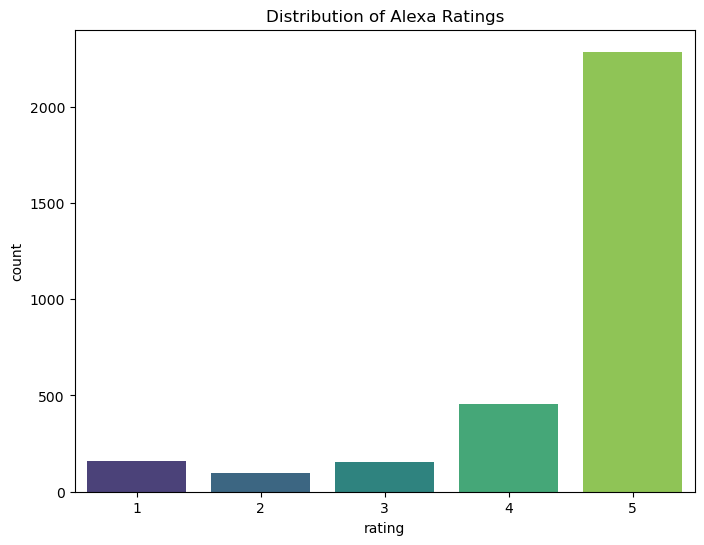

In [124]:
## plotting the countplot for the rating values
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data= df, palette='viridis')
plt.title('Distribution of Alexa Ratings')
plt.show()

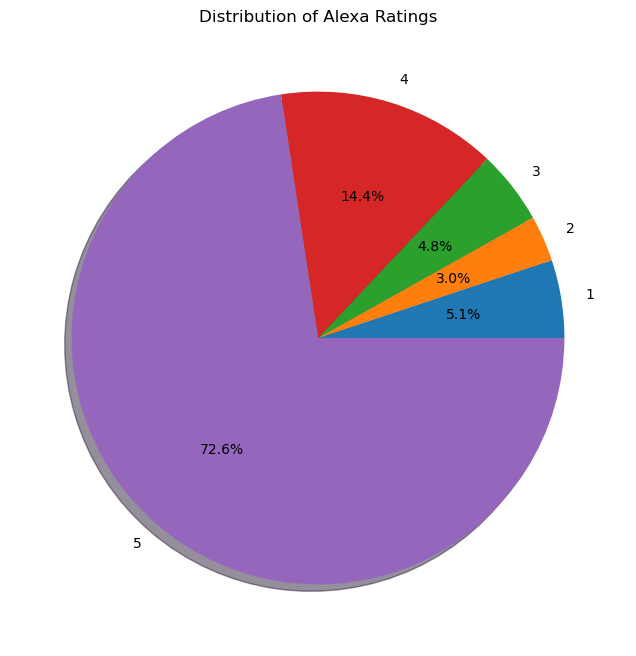

In [125]:
## plotting the piechart for the rating values
rating_counts = df['rating'].value_counts().sort_index()
plt.figure(figsize=(10, 8))
plt.pie(rating_counts, labels=rating_counts.index, shadow = True, autopct='%1.1f%%')
plt.title('Distribution of Alexa Ratings')
plt.show()

<Axes: >

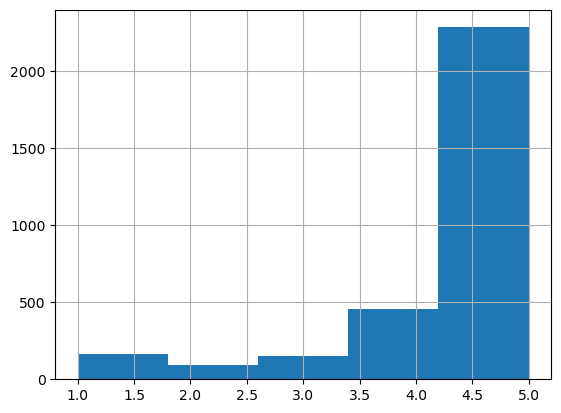

In [126]:
df['rating'].hist(bins = 5)

In [127]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

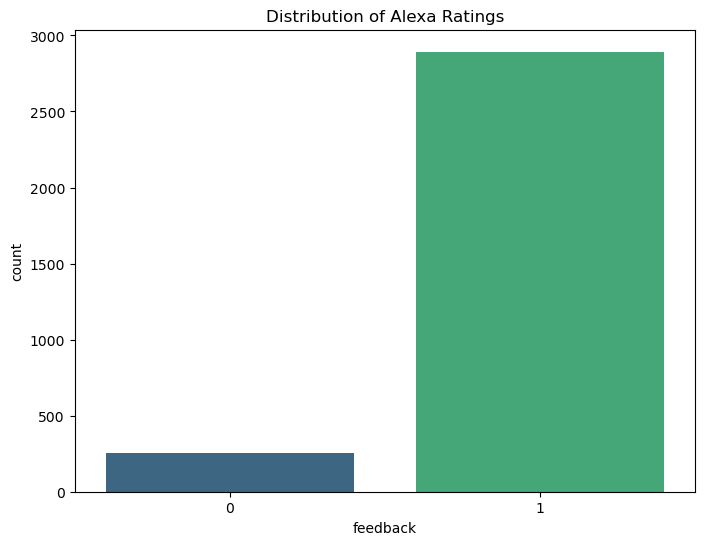

In [128]:
## plotting the countplot for the rating values
plt.figure(figsize=(8, 6))
sns.countplot(x='feedback', data= df, palette='viridis')
plt.title('Distribution of Alexa Ratings')
plt.show()

In [129]:
df['feedback'].value_counts()/df.shape[0]*100

feedback
1    91.870435
0     8.129565
Name: count, dtype: float64

In [130]:
#Understanding feedback based on the rating
df.groupby('feedback')['rating'].value_counts()

feedback  rating
0         1          161
          2           95
1         5         2286
          4          455
          3          152
Name: count, dtype: int64

<Axes: ylabel='proportion'>

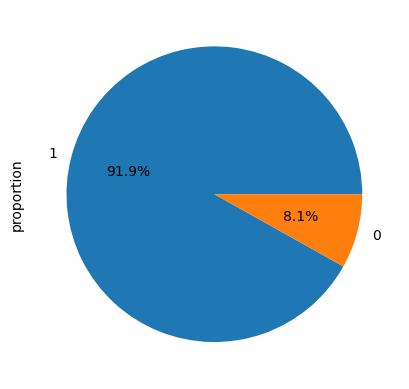

In [131]:
## plotting the piechart for the feedback values
df['feedback'].value_counts(normalize=True).plot(kind='pie', autopct="%1.1f%%")

## Above analysis implies that: 1 and 2 rating indicates negative review & 3, 4 and 5 indicated a positive review.

## Feedback distribution

#### 91.87% reviews are positive
####  8.13% reviews are negative

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


### Analyze Variation column

In [133]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

<Axes: xlabel='variation'>

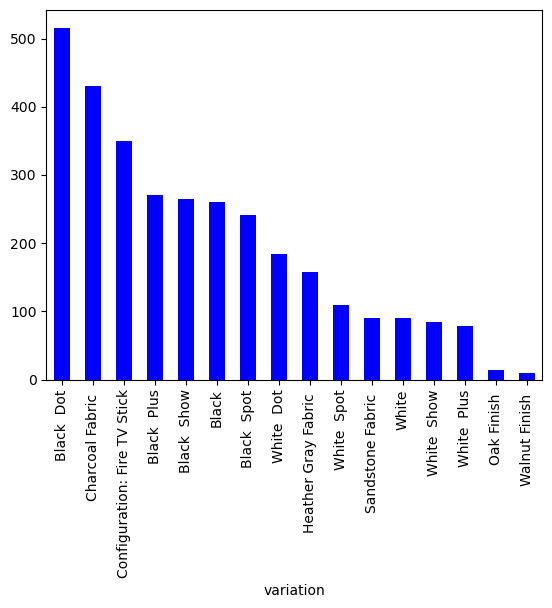

In [134]:
df['variation'].value_counts().plot(kind='bar', color='blue')

In [135]:
df['variation'].value_counts(normalize=True)*100

variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: proportion, dtype: float64

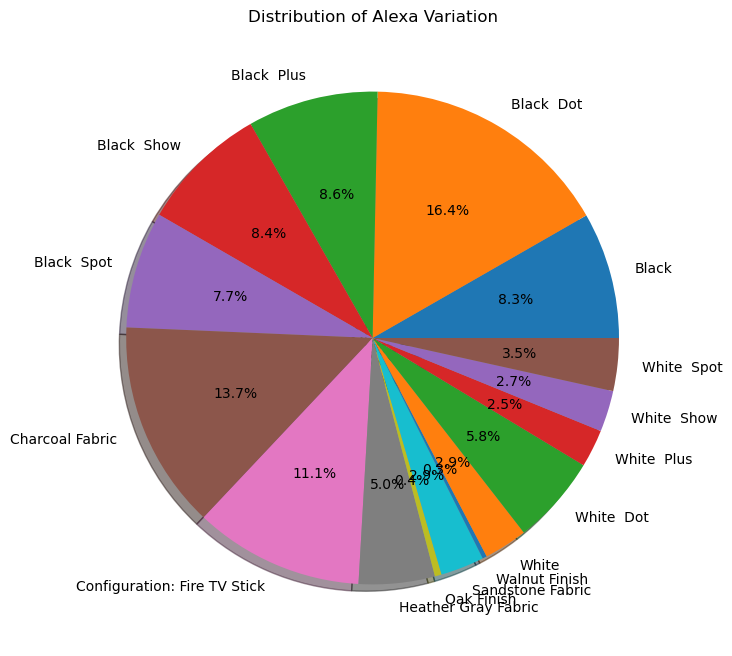

In [136]:

var_counts = df['variation'].value_counts().sort_index()
plt.figure(figsize=(10, 8))
plt.pie(var_counts, labels=var_counts.index, shadow = True, autopct='%1.1f%%')
plt.title('Distribution of Alexa Variation')
plt.show()

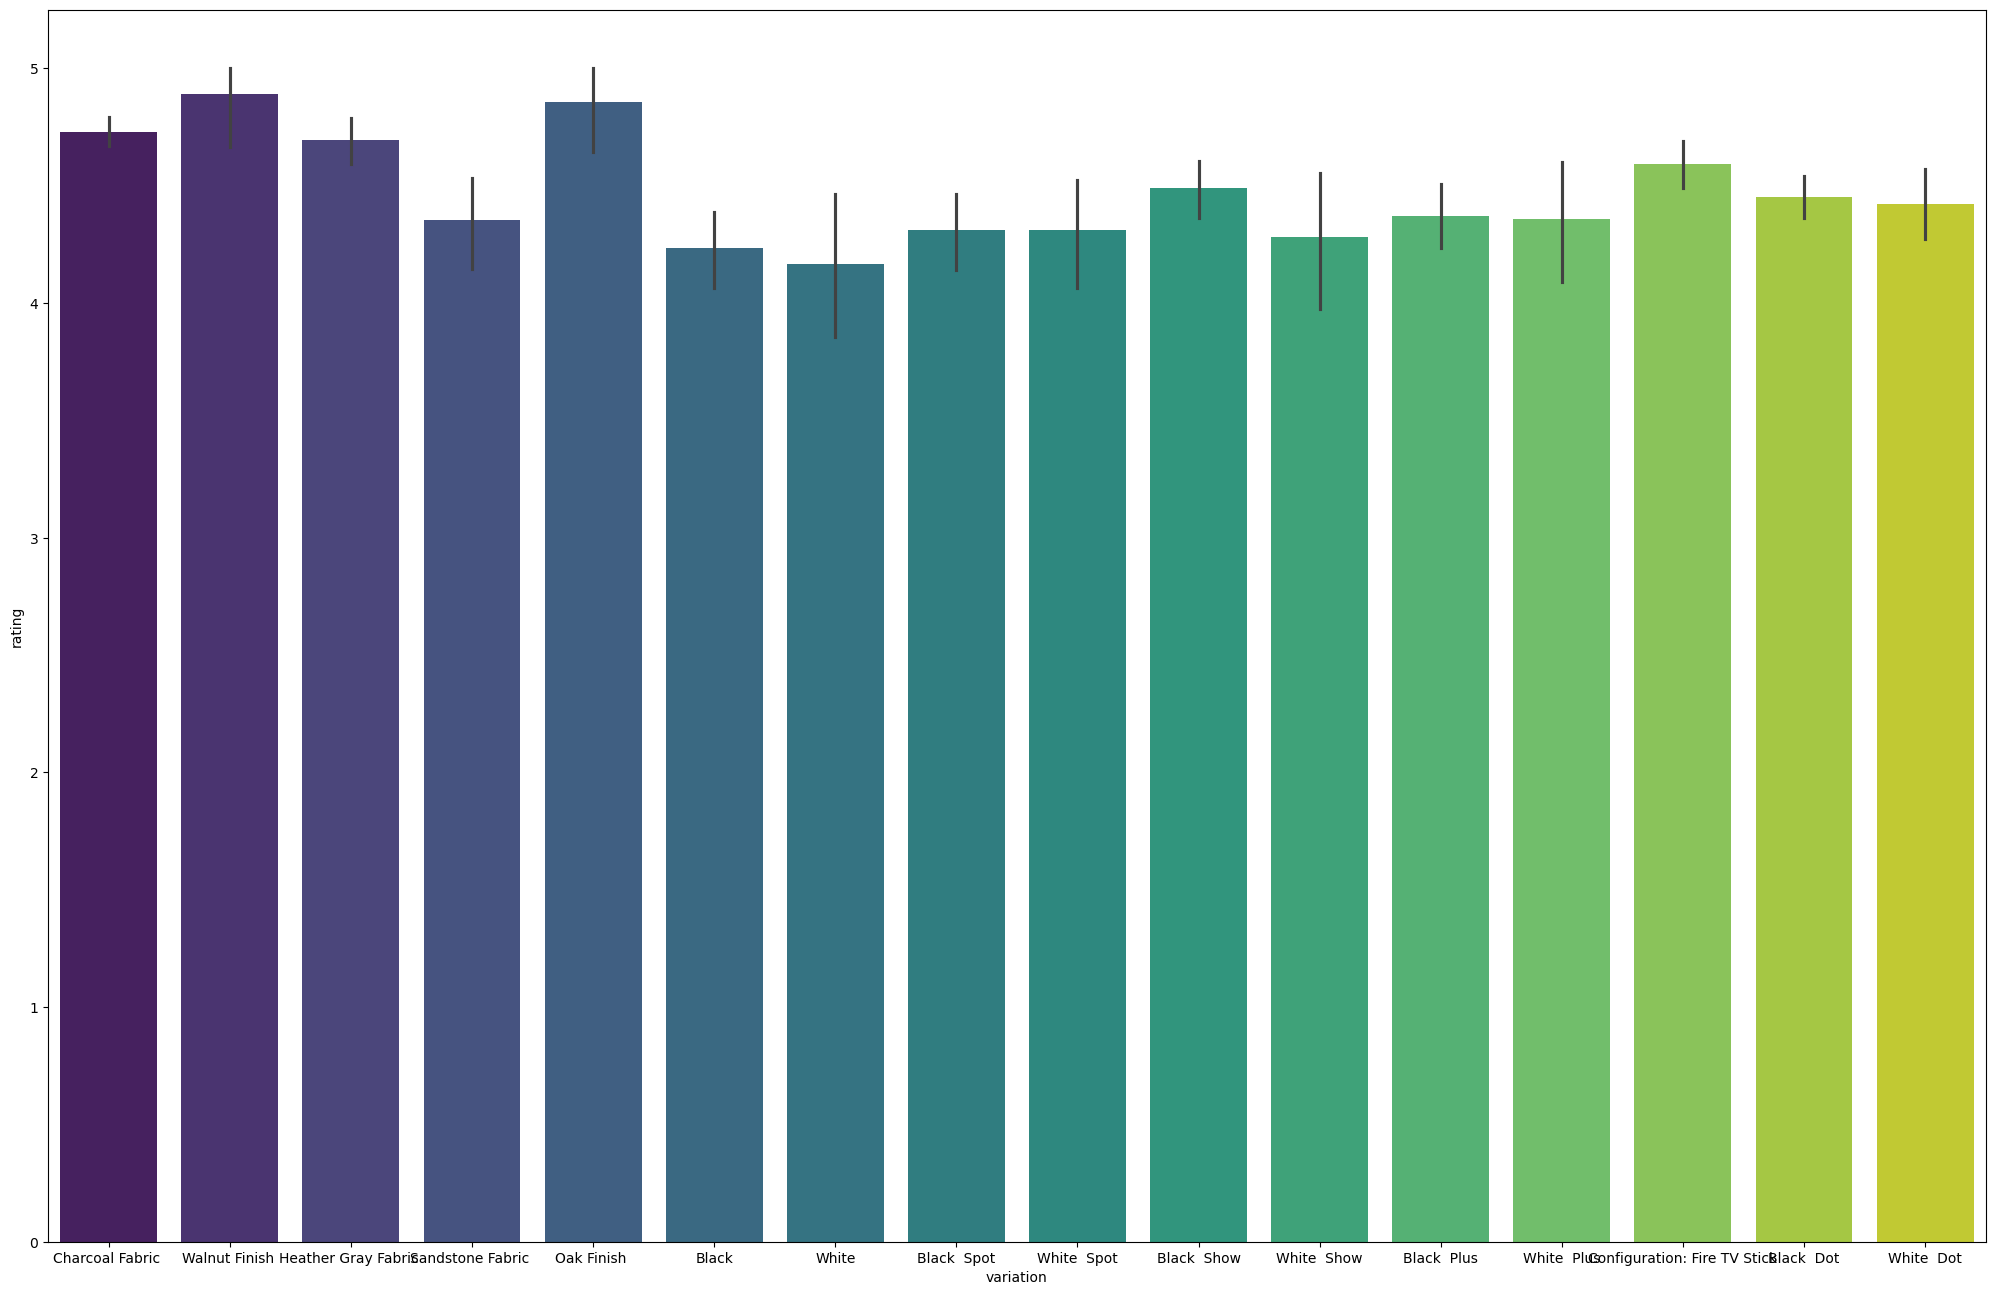

In [137]:
plt.figure(figsize = (25,16))
sns.barplot(x = 'variation', y='rating', data = df, palette = 'viridis')
plt.show()

<Axes: xlabel='variation'>

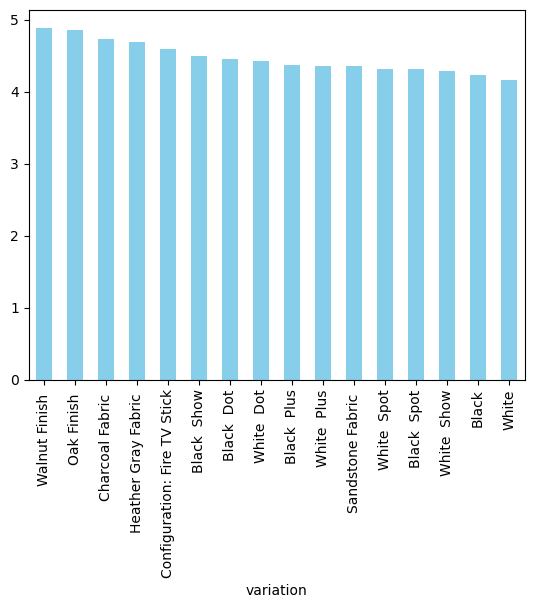

In [138]:
#variation vs rating
df.groupby('variation')['rating'].mean().sort_values(ascending=False).plot(kind='bar',color='skyblue')

<Axes: xlabel='variation'>

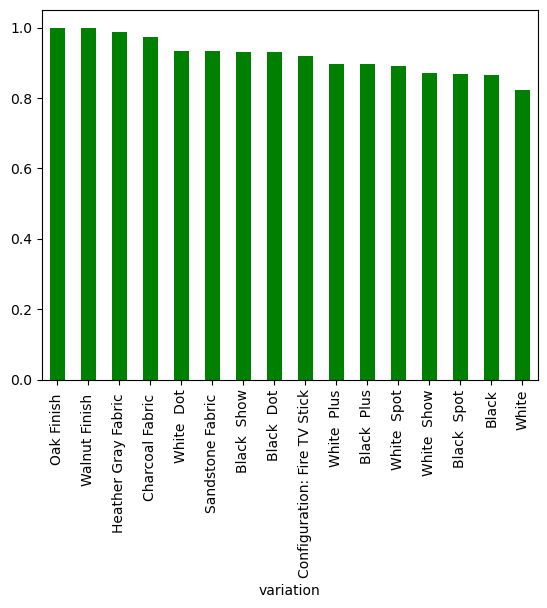

In [139]:
#variation vs feedback
df.groupby('variation')['feedback'].mean().sort_values(ascending=False).plot(kind='bar',color='green')

In [140]:
## Relationship between variation and rating,feedback & length
df.groupby('variation')[['rating','feedback','length']].mean().sort_values(by='rating' ,ascending=False)

,rating,feedback,length
variation,,,
Walnut Finish,4.888889,1.000000,137.666667
Oak Finish,4.857143,1.000000,103.714286
Charcoal Fabric,4.730233,0.972093,119.118605
Heather Gray Fabric,4.694268,0.987261,117.197452
Configuration: Fire TV Stick,4.591429,0.920000,86.542857
Black Show,4.490566,0.932075,146.203774
Black Dot,4.453488,0.930233,113.920543
White Dot,4.423913,0.934783,94.913043
Black Plus,4.370370,0.896296,185.796296


### Analyzing length column

In [141]:
df['length'].value_counts()

length
1      81
11     48
13     44
8      41
18     37
       ..
395     1
326     1
398     1
321     1
353     1
Name: count, Length: 490, dtype: int64

In [142]:
df['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

<Axes: xlabel='length', ylabel='Count'>

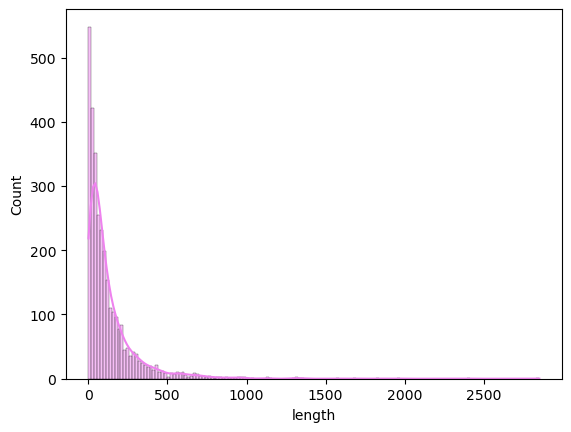

In [143]:
# Distribution of Length
sns.histplot(data=df, x='length', kde=True, color='violet')

<Axes: xlabel='length', ylabel='Count'>

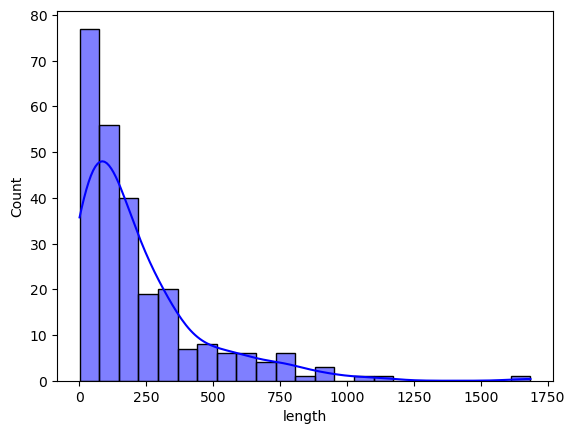

In [144]:
# Distribution of Length for negative feedback (0)
sns.histplot(df[df['feedback']==0]['length'], kde=True, color='blue')

<Axes: xlabel='length', ylabel='Count'>

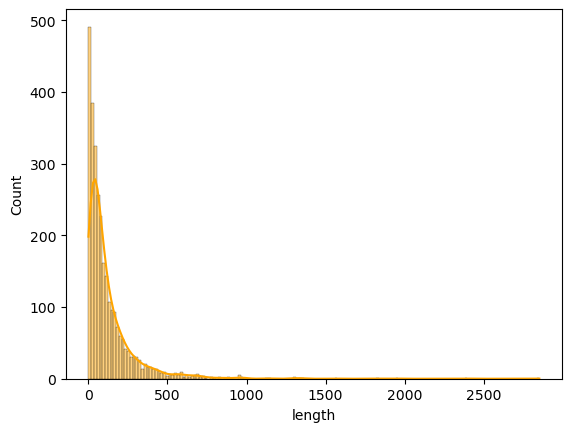

In [145]:
# Distribution of Length for positive feedback (1)
sns.histplot(df[df['feedback']==1]['length'], kde=True, color='orange')

<Axes: xlabel='rating'>

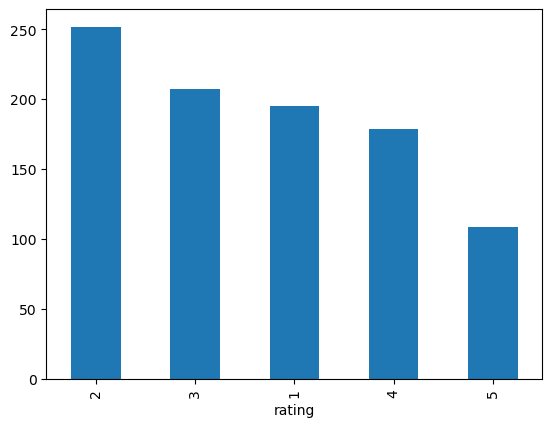

In [146]:
## Relationshio between rating and mean value of length
df.groupby('rating')['length'].mean().sort_values(ascending=False).plot.bar()

### Analysis of verified_reviews

In [147]:
#we are taking the english stopwords and storing them in cv variable  and then fitting it into our dataset
# this step filters all the stop words from the reviews column
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

In [148]:
review_string = " ".join(df['verified_reviews'])

In [149]:
review_string

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

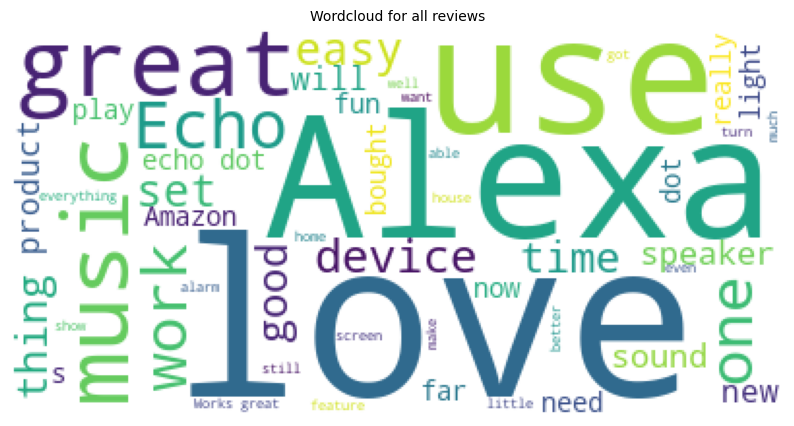

In [150]:
from wordcloud import WordCloud
# Combine all reviews

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot WordCloud for all the reviews
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(review_string))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [151]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only

#finding unique words in positive and negative reviews and Convert back to string

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)


unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


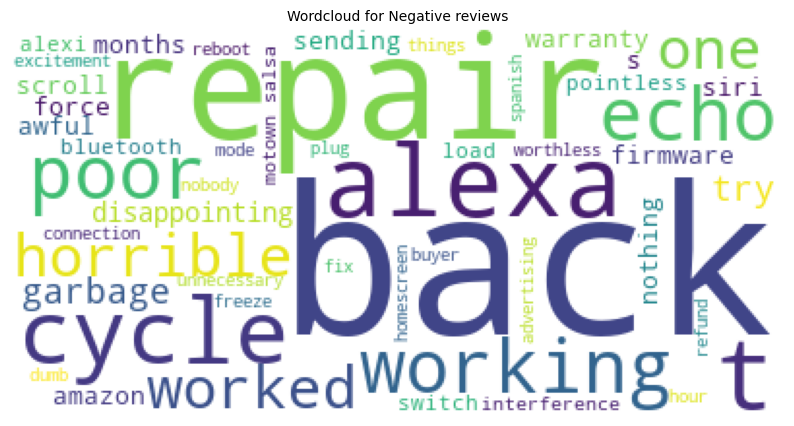

In [152]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for Negative reviews', fontsize=10)
plt.axis('off')
plt.show()

### Negative words can be seen in the above word cloud - repair, horrible, garbage, poor, disappointing, etc.

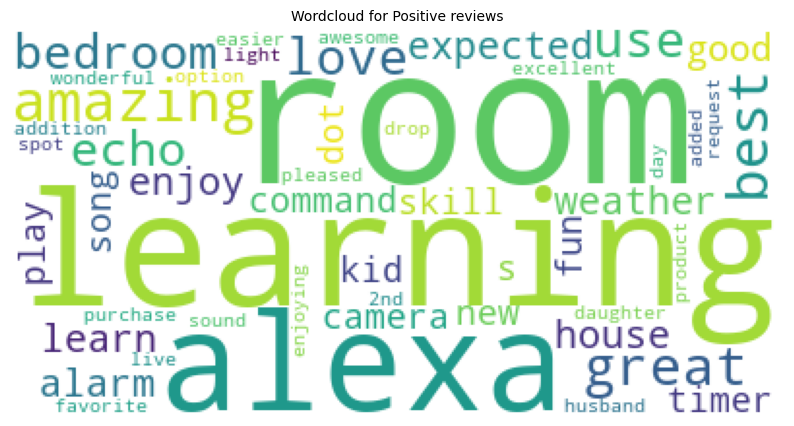

In [153]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for Positive reviews', fontsize=10)
plt.axis('off')
plt.show()

#### Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

### Data Preprocessing and Modelling

In [154]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [155]:
## Dropping Date columns as it does not provide any meaning info
df.drop('date',axis=1,inplace=True)
df.head()

,rating,variation,verified_reviews,feedback,length
0,5,Charcoal Fabric,Love my Echo!,1,13
1,5,Charcoal Fabric,Loved it!,1,9
2,4,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,Charcoal Fabric,Music,1,5


In [156]:
# For positive and negetive sentiment analysis we are considering 3,4,5 as feedback 1
# and we are considering 1,2 as negetive feedback ie 0 , so we can remove rating. Also lenght was added for analysis purpose 
df.drop(['rating', 'length'], axis=1, inplace=True)

In [157]:
df.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


In [158]:
from tqdm import tqdm

# Setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()


preprocessed_reviews = []

for sentence in tqdm(df['verified_reviews'].values):
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)     # Keep only letters and remove anything other than that
    sentence = sentence.lower()                       # Lowercase
    words = sentence.split()                          # Tokenize
    ## words = [ps.stem(word) for word in words if not word in stopwords]
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
    cleaned = ' '.join(words)                         # Rejoin
    preprocessed_reviews.append(cleaned)

100%|████████████████████████████████████| 3149/3149 [00:00<00:00, 36514.86it/s]


In [159]:
preprocessed_reviews

['love echo',
 'loved',
 'sometimes playing game answer question correctly alexa say got wrong answer like able turn light away home',
 'lot fun thing yr old learns dinosaur control light play game like category nice sound playing music well',
 'music',
 'received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else',
 'without cellphone cannot use many feature ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random question hear response seem smartbon politics yet',
 'think th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house',
 'look great',
 'love listened song heard since childhood get news weather information great',
 'sent year old dad talk constantly',
 'love learning knew thing eveyday still figuring everything work far easy use understand make laugh time',
 'purchased mother knee prob

In [160]:
## This code creates a Count Vectorizer limited to the top 2500 most frequent words and transforms the text corpus into a document-term matrix. Here's the breakdown:

cv = CountVectorizer(max_features=2500)
x = cv.fit_transform(preprocessed_reviews).toarray()

In [161]:
y = df['feedback'].values

In [162]:
#shape of x and y
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (3149, 2500)
y shape: (3149,)


In [163]:
## Splitting the data into train and test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [164]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform it
x_train_scaled = scaler.fit_transform(x_train)

# Transform test data (using the same scaler as fitted on training data)
X_test_scaled = scaler.transform(x_test)

In [165]:
# Function to perform the model evaluation
def evaluate_model(model, x_train, y_train, x_test, y_test):
    
    # Make model fit data
    model.fit(x_train, y_train)
    
    # Make model predict on train and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Get accuracy, precsion, recall and F1 Score on training and testing data
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    # Precision score
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)

    # recall score
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    # F1 Score
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    
    # Confusion matrix 
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'Test accuracy: {accuracy_test}\n')
    print(f'Test precision: {precision_test}\n')
    print(f'Test Recall: {recall_test}\n')
    print(f'Test F1 score: {f1_test}\n')
    
    # Classification report
    cl_report = classification_report(y_test, y_test_pred)
    print(f'classification report:\n{cl_report}')

    # Calculate ROC AUC score
    auc_score_train = roc_auc_score(y_train, y_train_pred)
    auc_score_test = roc_auc_score(y_test, y_test_pred)
    print("\nTrain ROC AUC:", auc_score_train)
    print("Test ROC AUC:", auc_score_test)

    # Plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    plt.plot([0,1],[0,1],color='navy', lw=2, linestyle='--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(auc_score_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(auc_score_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    model_score = [accuracy_train, accuracy_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test, auc_score_test]

    return model_score

In [166]:
# Create a score dataframe
score = pd.DataFrame(index = ['Accuracy Train', 'Accuracy Test','Recall Train','Recall Test','Precision Train', 'Precision Test', 'F1 macro Train', 'F1 macro Test','roc auc score'])
score = score.sort_values(by='Accuracy Test', ascending=False, axis=1)

## ML Model - Logistic Regression

In [167]:
## Build Logistic Regression Model
lr_model = LogisticRegression()

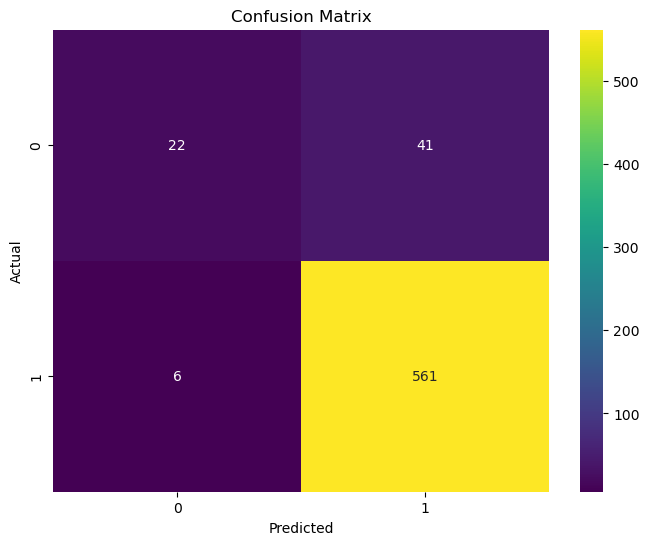

Test accuracy: 0.9253968253968254

Test precision: 0.9318936877076412

Test Recall: 0.9894179894179894

Test F1 score: 0.9597946963216425

classification report:
              precision    recall  f1-score   support

           0       0.79      0.35      0.48        63
           1       0.93      0.99      0.96       567

    accuracy                           0.93       630
   macro avg       0.86      0.67      0.72       630
weighted avg       0.92      0.93      0.91       630


Train ROC AUC: 0.8471502590673575
Test ROC AUC: 0.6693121693121693


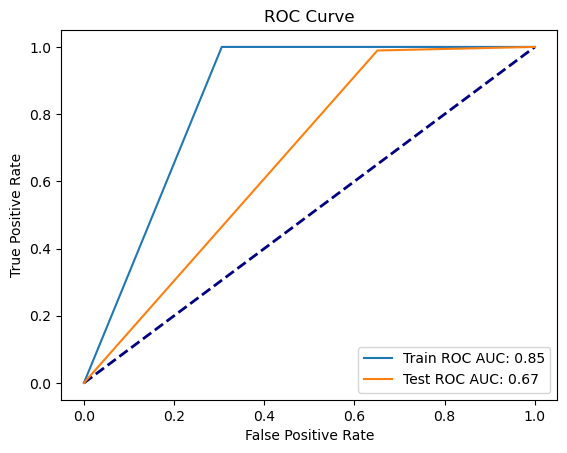

In [168]:
## Visualize the evaluation metric
lr_score = evaluate_model(lr_model,  x_train, y_train, x_test, y_test)

In [169]:
# Updated Evaluation metric Score Chart
score['Logistic Regression'] = lr_score
score

,Logistic Regression
Accuracy Train,0.976578
Accuracy Test,0.925397
Recall Train,1.000000
Recall Test,0.989418
Precision Train,0.975262
Precision Test,0.931894
F1 macro Train,0.987476
F1 macro Test,0.959795
roc auc score,0.669312


In [170]:
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],         # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm
    'max_iter': [100, 200, 300],                  # Maximum iterations
    'class_weight': ['balanced', None]            # Class weights
}

# Initialize the model
lr_tuned_model = LogisticRegression(random_state=42)

# Basic K-Fold cross validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomSearchCV
random_search_lr = RandomizedSearchCV(lr_tuned_model, param_grid_lr,cv=kfold, scoring = 'accuracy', n_jobs= -1, random_state=42)

# Fit the RandomSearchCV to the training data
random_search_lr.fit(x_train, y_train)

# Select the best hyperparameters
best_params_lr = random_search_lr.best_params_
print("Best hyperparameters: ", best_params_lr)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was 

Best hyperparameters:  {'solver': 'sag', 'penalty': None, 'max_iter': 100, 'class_weight': None, 'C': 0.01}


In [171]:

# Initiate model with best parameters
lr_tuned_model = LogisticRegression(class_weight = best_params_lr['class_weight'],
                        max_iter = best_params_lr['max_iter'],
                        solver = best_params_lr['solver'],
                        penalty = best_params_lr['penalty'],
                                  C = best_params_lr['C'] )

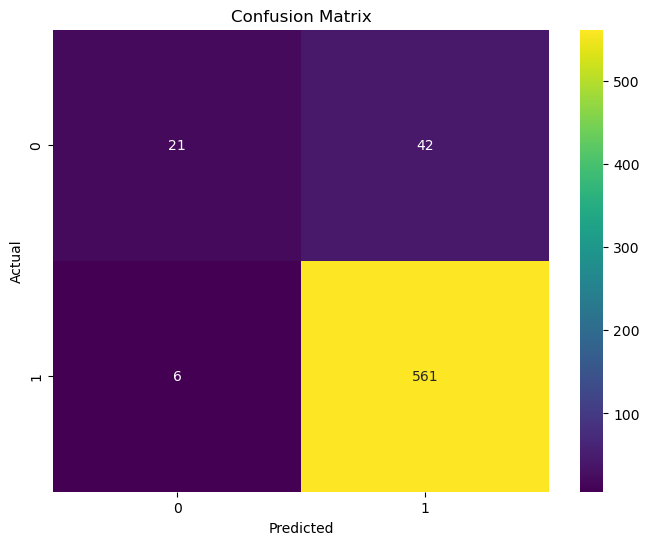

Test accuracy: 0.9238095238095239

Test precision: 0.9303482587064676

Test Recall: 0.9894179894179894

Test F1 score: 0.958974358974359

classification report:
              precision    recall  f1-score   support

           0       0.78      0.33      0.47        63
           1       0.93      0.99      0.96       567

    accuracy                           0.92       630
   macro avg       0.85      0.66      0.71       630
weighted avg       0.92      0.92      0.91       630


Train ROC AUC: 0.8419689119170984
Test ROC AUC: 0.6613756613756614


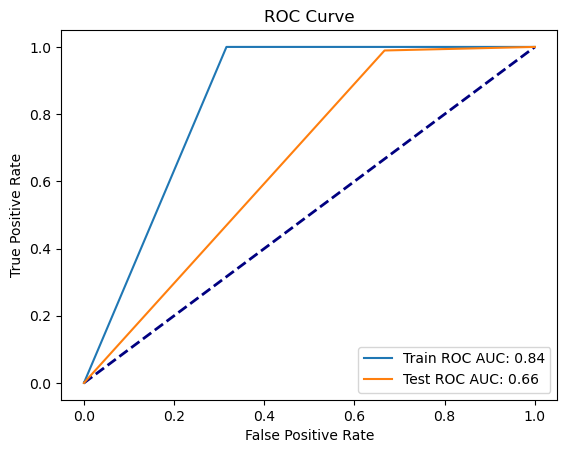

In [172]:
lr_tuned_score = evaluate_model(lr_tuned_model, x_train, y_train, x_test, y_test)

In [173]:
# Updated Evaluation metric Score Chart
score['LR Tuned'] = lr_tuned_score
score

,Logistic Regression,LR Tuned
Accuracy Train,0.976578,0.975784
Accuracy Test,0.925397,0.923810
Recall Train,1.000000,1.000000
Recall Test,0.989418,0.989418
Precision Train,0.975262,0.974445
Precision Test,0.931894,0.930348
F1 macro Train,0.987476,0.987057
F1 macro Test,0.959795,0.958974
roc auc score,0.669312,0.661376


## ML Model - 2 : Random Forest Classifier

In [174]:
## Build Random Forest Model
rf_model = RandomForestClassifier()

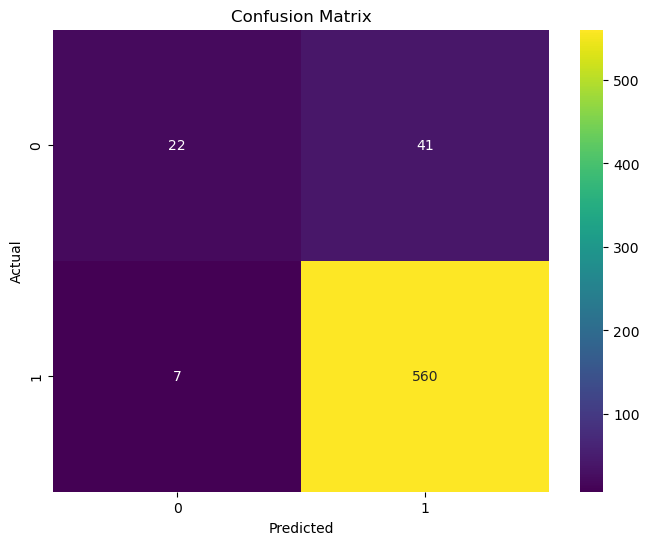

Test accuracy: 0.9238095238095239

Test precision: 0.9317803660565723

Test Recall: 0.9876543209876543

Test F1 score: 0.958904109589041

classification report:
              precision    recall  f1-score   support

           0       0.76      0.35      0.48        63
           1       0.93      0.99      0.96       567

    accuracy                           0.92       630
   macro avg       0.85      0.67      0.72       630
weighted avg       0.91      0.92      0.91       630


Train ROC AUC: 0.9533678756476685
Test ROC AUC: 0.6684303350970018


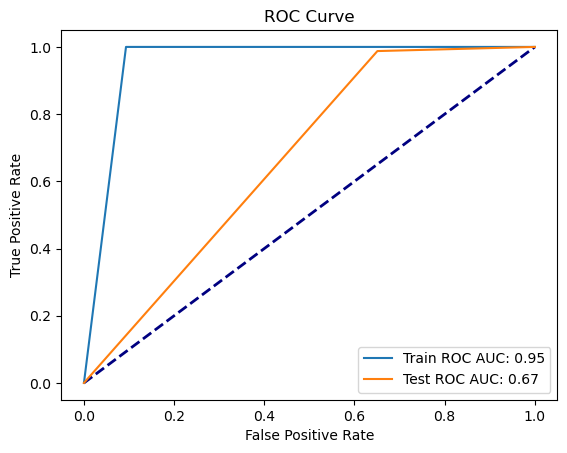

In [175]:
## Visualize the evaluation metric
rf_score = evaluate_model(rf_model, x_train, y_train, x_test, y_test)

In [176]:
# Updated Evaluation metric Score Chart
score['Random Forest'] = rf_score
score

,Logistic Regression,LR Tuned,Random Forest
Accuracy Train,0.976578,0.975784,0.992854
Accuracy Test,0.925397,0.923810,0.923810
Recall Train,1.000000,1.000000,1.000000
Recall Test,0.989418,0.989418,0.987654
Precision Train,0.975262,0.974445,0.992321
Precision Test,0.931894,0.930348,0.931780
F1 macro Train,0.987476,0.987057,0.996146
F1 macro Test,0.959795,0.958974,0.958904
roc auc score,0.669312,0.661376,0.668430


In [177]:
from sklearn.model_selection import StratifiedKFold

# Define the hyperparameter grid
rf_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [8, 9, 10, 11, 12,13, 14, 15],
              'min_samples_split': [2, 3, 4, 5]}

# Initialize the model
rf = RandomForestClassifier()

# Repeated stratified kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomSearchCV
random_search = RandomizedSearchCV(rf, rf_grid,cv=skf, n_iter=10, n_jobs=-1)

# Fit the RandomSearchCV to the training data
random_search.fit(x_train, y_train)

# Select the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 9}


In [178]:
rf_model_tuned = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth=best_params['max_depth'] ,min_samples_split=best_params['min_samples_split'])

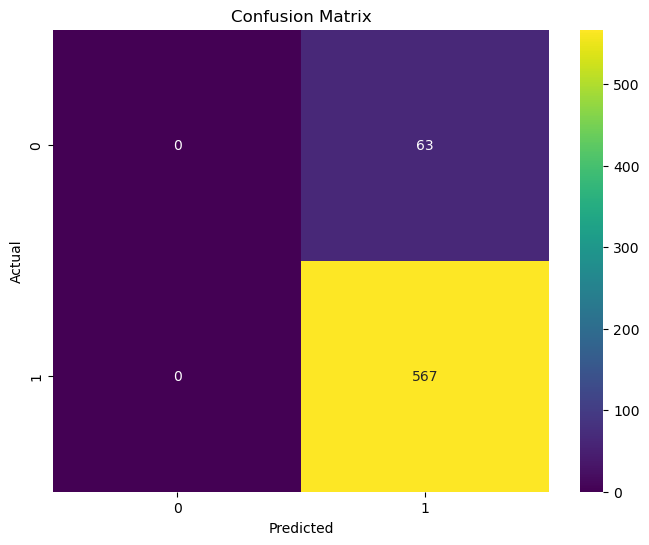

Test accuracy: 0.9

Test precision: 0.9

Test Recall: 1.0

Test F1 score: 0.9473684210526316

classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.90      1.00      0.95       567

    accuracy                           0.90       630
   macro avg       0.45      0.50      0.47       630
weighted avg       0.81      0.90      0.85       630


Train ROC AUC: 0.5310880829015544
Test ROC AUC: 0.5


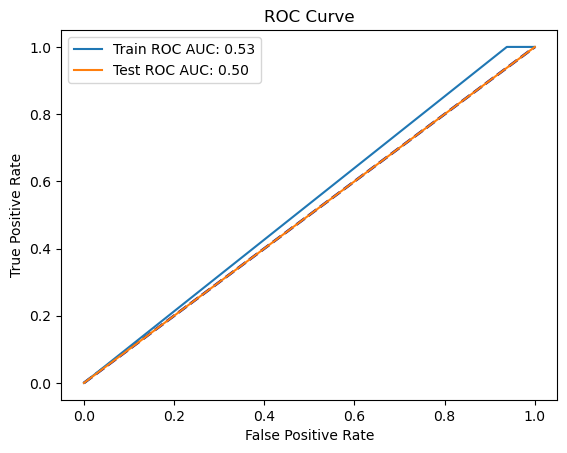

In [179]:
rf_tuned_score = evaluate_model(rf_model_tuned,  x_train, y_train, x_test, y_test)

In [180]:
score['RF Tuned'] = rf_tuned_score
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.0,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.0,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.0,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.0,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000


## ML Model - 3 : Multinomial Naive bayes

In [181]:
## Build Multinomial Naive bayes Model
mnb_model = MultinomialNB()

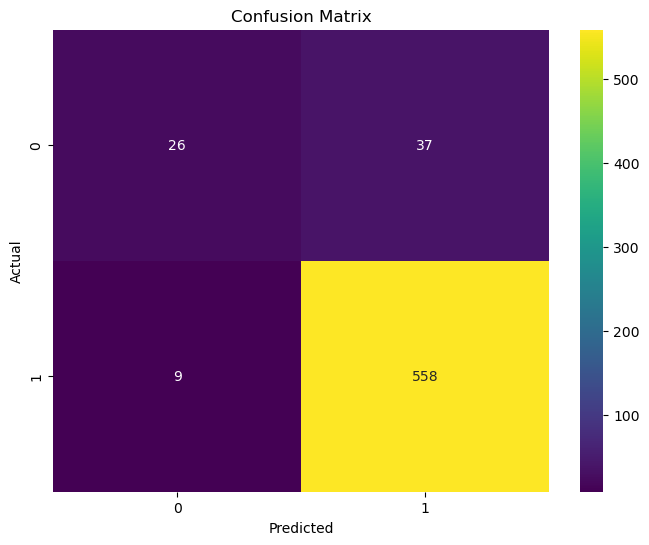

Test accuracy: 0.926984126984127

Test precision: 0.9378151260504202

Test Recall: 0.9841269841269841

Test F1 score: 0.9604130808950087

classification report:
              precision    recall  f1-score   support

           0       0.74      0.41      0.53        63
           1       0.94      0.98      0.96       567

    accuracy                           0.93       630
   macro avg       0.84      0.70      0.75       630
weighted avg       0.92      0.93      0.92       630


Train ROC AUC: 0.8018301783399195
Test ROC AUC: 0.6984126984126984


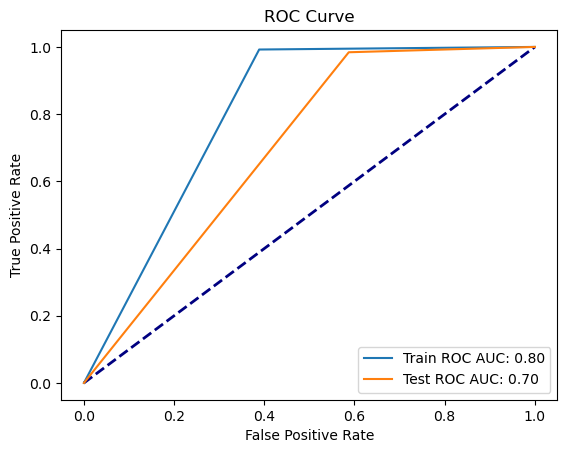

In [182]:
## Visualize the evaluation metric
mnb_score = evaluate_model(mnb_model,  x_train, y_train, x_test, y_test)

In [183]:
# Updated Evaluation metric Score Chart
score['MultinomialNB'] = mnb_score
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413


## Cross validation and Hyperparameter tunning

In [184]:
## Cross- Validation & Hyperparameter Tuning

param_grid_mnb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],    # Controls smoothing
    'fit_prior': [True, False]             # Whether to learn class priors
}
# Initialize the model
mnb = MultinomialNB()

# Basic K-Fold cross validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomSearchCV
random_search_mnb = RandomizedSearchCV(mnb, param_grid_mnb,cv=kfold, n_iter=10, n_jobs=-1, verbose=1,random_state=42)

# Fit the RandomSearchCV to the training data
random_search_mnb.fit(x_train, y_train)

# Select the best hyperparameters
best_params_mnb = random_search_mnb.best_params_
print("Best hyperparameters: ", best_params_mnb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters:  {'fit_prior': True, 'alpha': 0.01}


In [213]:
## Build MultinomialNB Model with optimal hyperparameter
mnb_model_tuned = MultinomialNB(fit_prior = best_params_mnb['fit_prior'], alpha= best_params_mnb['alpha'])

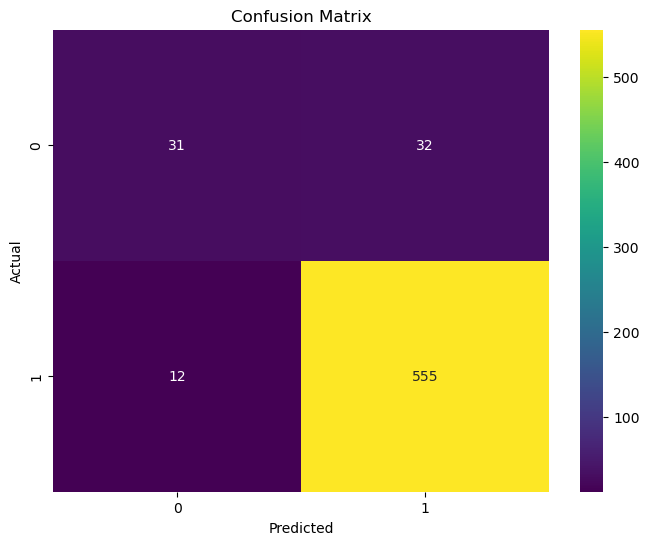

Test accuracy: 0.9301587301587302

Test precision: 0.9454855195911414

Test Recall: 0.9788359788359788

Test F1 score: 0.9618717504332756

classification report:
              precision    recall  f1-score   support

           0       0.72      0.49      0.58        63
           1       0.95      0.98      0.96       567

    accuracy                           0.93       630
   macro avg       0.83      0.74      0.77       630
weighted avg       0.92      0.93      0.92       630


Train ROC AUC: 0.8866663845067473
Test ROC AUC: 0.7354497354497355


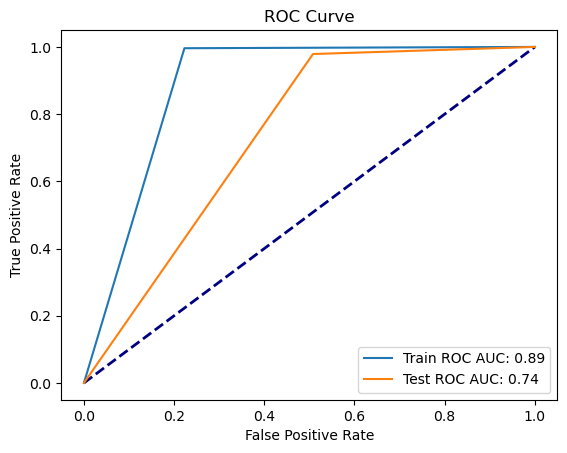

In [214]:
mnb_tuned_score = evaluate_model(mnb_model_tuned,  x_train, y_train, x_test, y_test)

In [215]:
score['MNB Tuned'] = mnb_tuned_score
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB,0.969432,0.912698,1.000000,0.980600,0.967957,0.926667,0.983717,0.952871,0.641093
DT,0.992854,0.915873,1.000000,0.950617,0.992321,0.955674,0.996146,0.953139,0.776896
SVM,0.964272,0.907937,1.000000,1.000000,0.962748,0.907200,0.981021,0.951342,0.539683
MLP,0.992854,0.928571,1.000000,0.984127,0.992321,0.939394,0.996146,0.961240,0.706349


## ML Model - 4 : XGBoost Classifier

In [216]:
xgb_model = XGBClassifier()

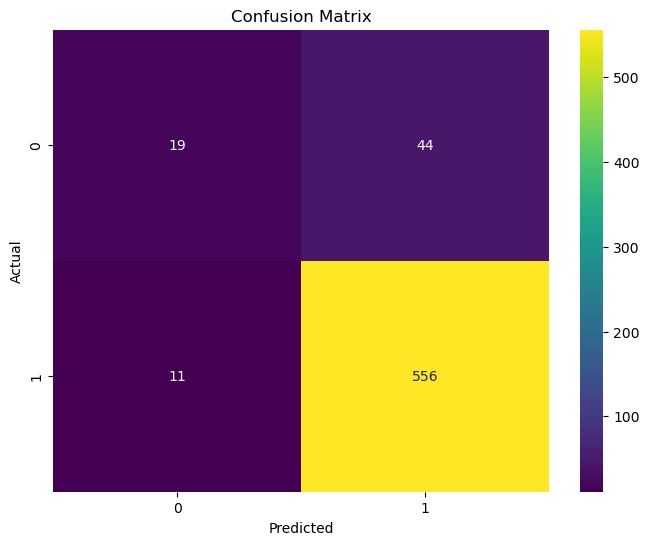

Test accuracy: 0.9126984126984127

Test precision: 0.9266666666666666

Test Recall: 0.9805996472663139

Test F1 score: 0.9528706083976007

classification report:
              precision    recall  f1-score   support

           0       0.63      0.30      0.41        63
           1       0.93      0.98      0.95       567

    accuracy                           0.91       630
   macro avg       0.78      0.64      0.68       630
weighted avg       0.90      0.91      0.90       630


Train ROC AUC: 0.8005181347150259
Test ROC AUC: 0.6410934744268078


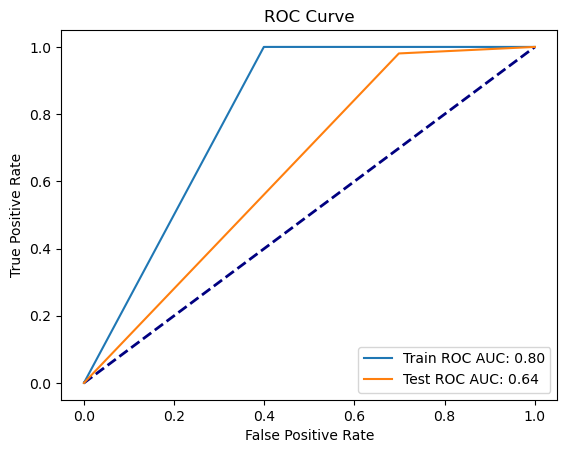

In [217]:
## Visualize the evaluation metric
xgb_score = evaluate_model(xgb_model,  x_train, y_train, x_test, y_test)

In [218]:
# Updated Evaluation metric Score Chart
score['XGB'] = xgb_score
score

,Logistic Regression,LR Tuned,Random Forest,RF Tuned,MultinomialNB,MNB Tuned,XGB,DT,SVM,MLP,MLP Tuned
Accuracy Train,0.976578,0.975784,0.992854,0.928146,0.963081,0.979357,0.969432,0.992854,0.964272,0.992854,0.992854
Accuracy Test,0.925397,0.923810,0.923810,0.900000,0.926984,0.930159,0.912698,0.915873,0.907937,0.928571,0.928571
Recall Train,1.000000,1.000000,1.000000,1.000000,0.992261,0.996131,1.000000,1.000000,1.000000,1.000000,1.000000
Recall Test,0.989418,0.989418,0.987654,1.000000,0.984127,0.978836,0.980600,0.950617,1.000000,0.984127,0.984127
Precision Train,0.975262,0.974445,0.992321,0.927802,0.968527,0.981780,0.967957,0.992321,0.962748,0.992321,0.992321
Precision Test,0.931894,0.930348,0.931780,0.900000,0.937815,0.945486,0.926667,0.955674,0.907200,0.939394,0.939394
F1 macro Train,0.987476,0.987057,0.996146,0.962549,0.980251,0.988903,0.983717,0.996146,0.981021,0.996146,0.996146
F1 macro Test,0.959795,0.958974,0.958904,0.947368,0.960413,0.961872,0.952871,0.953139,0.951342,0.961240,0.961240
roc auc score,0.669312,0.661376,0.668430,0.500000,0.698413,0.735450,0.641093,0.776896,0.539683,0.706349,0.706349


In [221]:
from sklearn.model_selection import StratifiedKFold

# Define the hyperparameter grid
xgb_param_grid = {'learning_rate': np.arange(0.01, 0.3, 0.01),
                  'max_depth': np.arange(3, 15, 1),
                  'n_estimators': np.arange(100, 200, 10)}

# Initialize the model
xgb2 = XGBClassifier(random_state=42)

# Repeated stratified kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomSearchCV
random_search_xgb = RandomizedSearchCV(xgb2, xgb_param_grid,cv=skf, n_iter=10, n_jobs=-1)

# Fit the RandomSearchCV to the training data
random_search_xgb.fit(x_train, y_train)

# Select the best hyperparameters
best_params_xgb = random_search_xgb.best_params_
print("Best hyperparameters: ", best_params_xgb)

Best hyperparameters:  {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.06}


In [223]:
# Building model with ideal hyperparamter
xgb_tuned_model = XGBClassifier(n_estimators = best_params_xgb['n_estimators'],
                                max_depth = best_params_xgb['max_depth'], 
                                learning_rate = best_params_xgb['learning_rate'])

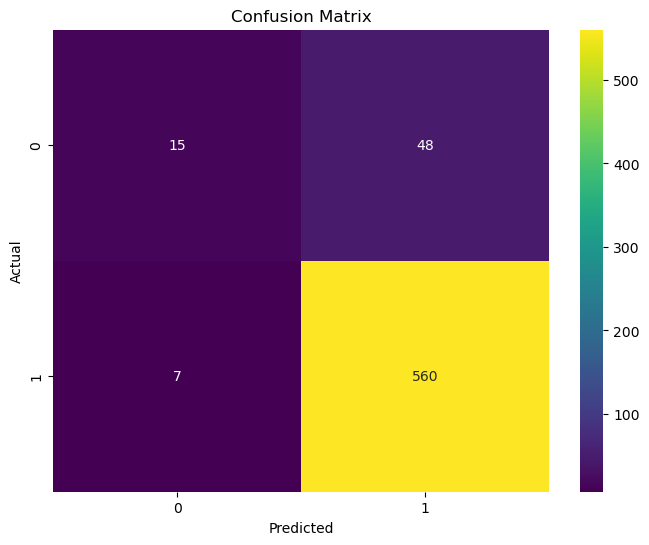

Test accuracy: 0.9126984126984127

Test precision: 0.9210526315789473

Test Recall: 0.9876543209876543

Test F1 score: 0.9531914893617021

classification report:
              precision    recall  f1-score   support

           0       0.68      0.24      0.35        63
           1       0.92      0.99      0.95       567

    accuracy                           0.91       630
   macro avg       0.80      0.61      0.65       630
weighted avg       0.90      0.91      0.89       630


Train ROC AUC: 0.7018575775531388
Test ROC AUC: 0.6128747795414462


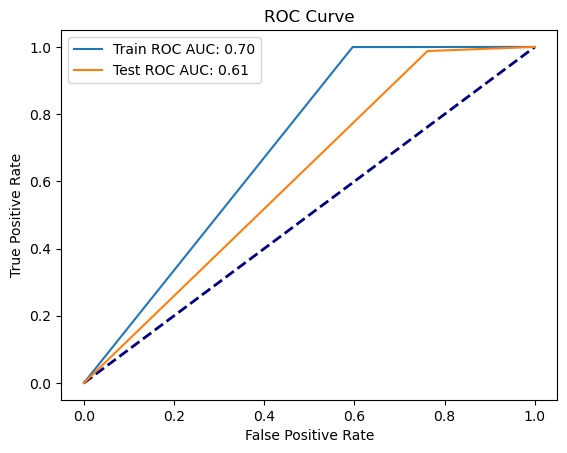

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB,0.969432,0.912698,1.000000,0.980600,0.967957,0.926667,0.983717,0.952871,0.641093
DT,0.992854,0.915873,1.000000,0.950617,0.992321,0.955674,0.996146,0.953139,0.776896
SVM,0.964272,0.907937,1.000000,1.000000,0.962748,0.907200,0.981021,0.951342,0.539683
MLP,0.992854,0.928571,1.000000,0.984127,0.992321,0.939394,0.996146,0.961240,0.706349


In [227]:
xgb_tuned_score = evaluate_model(xgb_tuned_model, x_train, y_train, x_test, y_test)
score['XGB Tuned'] = xgb_tuned_score
score.T

### ML Model 5 - Decision Tree

In [192]:
dt_model = DecisionTreeClassifier()

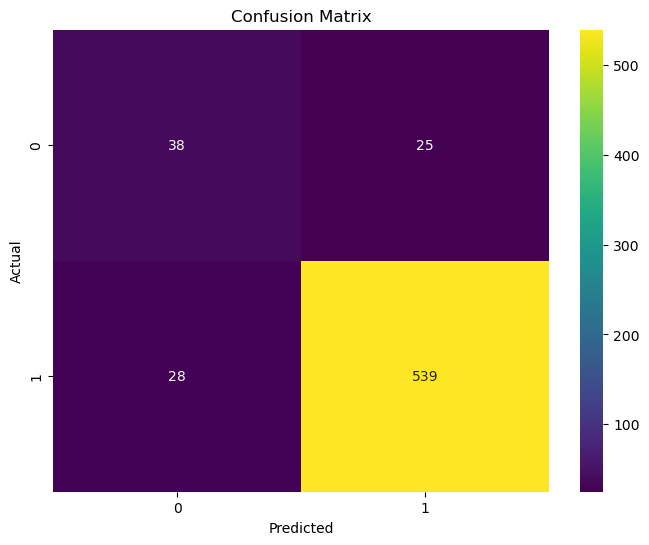

Test accuracy: 0.9158730158730158

Test precision: 0.9556737588652482

Test Recall: 0.9506172839506173

Test F1 score: 0.9531388152077808

classification report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        63
           1       0.96      0.95      0.95       567

    accuracy                           0.92       630
   macro avg       0.77      0.78      0.77       630
weighted avg       0.92      0.92      0.92       630


Train ROC AUC: 0.9533678756476685
Test ROC AUC: 0.7768959435626104


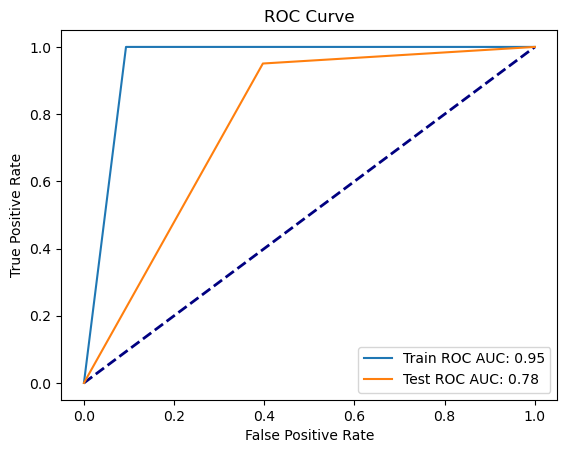

In [193]:
## Visualize the evaluation metric
dt_score = evaluate_model(dt_model,  x_train, y_train, x_test, y_test)
score['DT'] = dt_score

In [232]:
# Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
dt_param_grid = {'max_depth' : [3,4,5,6,7,8],
        'min_samples_split' : np.arange(2,8),
        'min_samples_leaf' : np.arange(10,20)}

# Initialize the model
dt = DecisionTreeClassifier()

# repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(dt, dt_param_grid, cv=rskf)

# Fit the GridSearchCV to the training data
grid_search_dt.fit(x_train, y_train)

# Select the best hyperparameters
best_params_dt = grid_search_dt.best_params_
print("Best hyperparameters: ", best_params_dt)

Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 2}


In [233]:
dt_tuned_model = DecisionTreeClassifier(max_depth = best_params_dt['max_depth'], 
                       min_samples_leaf = best_params_dt['min_samples_leaf'], 
                       min_samples_split = best_params_dt['min_samples_split'])

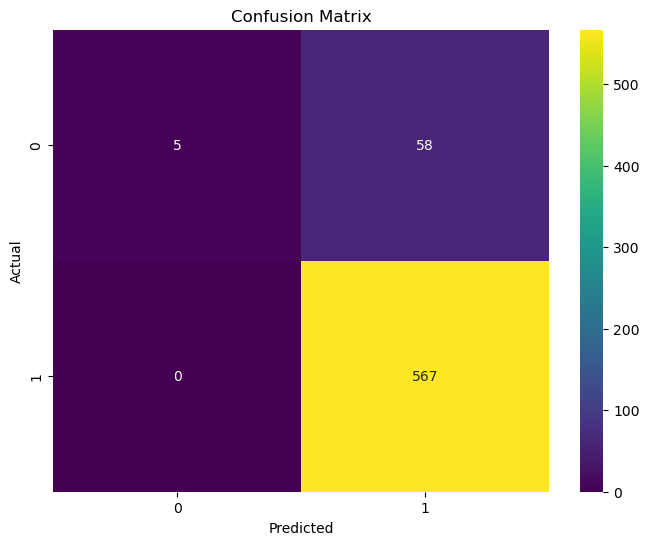

Test accuracy: 0.9079365079365079

Test precision: 0.9072

Test Recall: 1.0

Test F1 score: 0.9513422818791947

classification report:
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        63
           1       0.91      1.00      0.95       567

    accuracy                           0.91       630
   macro avg       0.95      0.54      0.55       630
weighted avg       0.92      0.91      0.87       630


Train ROC AUC: 0.766839378238342
Test ROC AUC: 0.5396825396825398


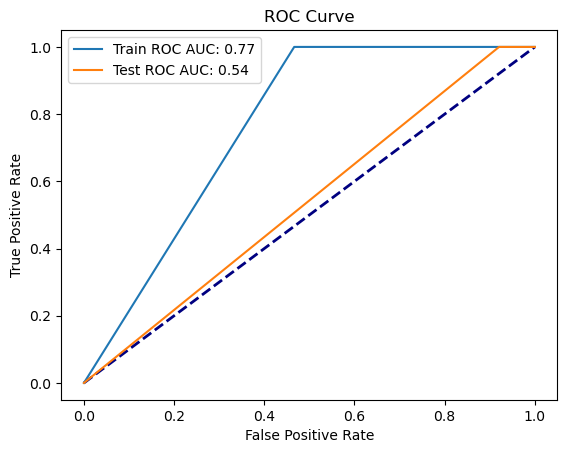

In [234]:
dt_tuned_score = evaluate_model(svm_model,  x_train, y_train, x_test, y_test)

In [235]:
score['DT Tuned'] = dt_tuned_score

## ML Model 6 - Support Vector Machine

In [194]:
## Building SVM model
svm_model = SVC()

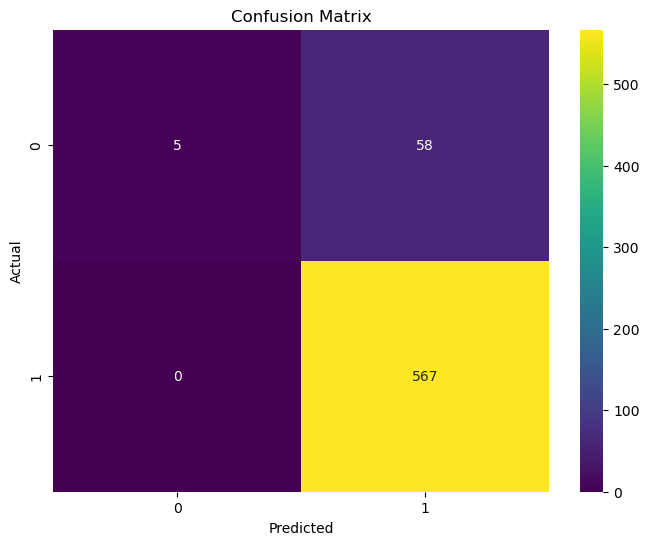

Test accuracy: 0.9079365079365079

Test precision: 0.9072

Test Recall: 1.0

Test F1 score: 0.9513422818791947

classification report:
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        63
           1       0.91      1.00      0.95       567

    accuracy                           0.91       630
   macro avg       0.95      0.54      0.55       630
weighted avg       0.92      0.91      0.87       630


Train ROC AUC: 0.766839378238342
Test ROC AUC: 0.5396825396825398


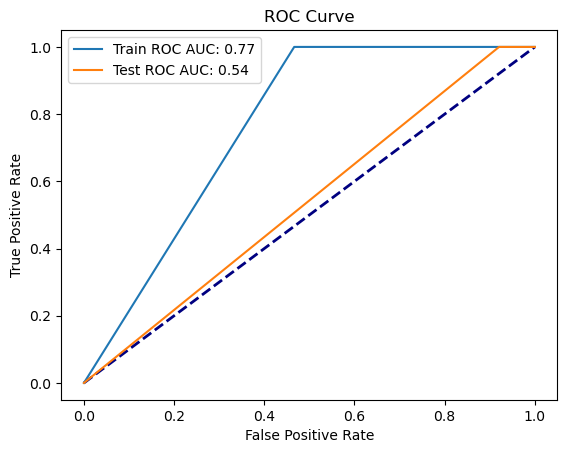

In [195]:
## Visualize the evaluation metric
svm_score = evaluate_model(svm_model,  x_train, y_train, x_test, y_test)
score['SVM'] = svm_score

In [196]:
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB,0.969432,0.912698,1.000000,0.980600,0.967957,0.926667,0.983717,0.952871,0.641093
DT,0.992854,0.915873,1.000000,0.950617,0.992321,0.955674,0.996146,0.953139,0.776896
SVM,0.964272,0.907937,1.000000,1.000000,0.962748,0.907200,0.981021,0.951342,0.539683


## ML Model 7 - multi-layer perceptron (MLP) neural network

In [197]:
## Build Multi-layer perceptron Model
nn_model = MLPClassifier(random_state=0)

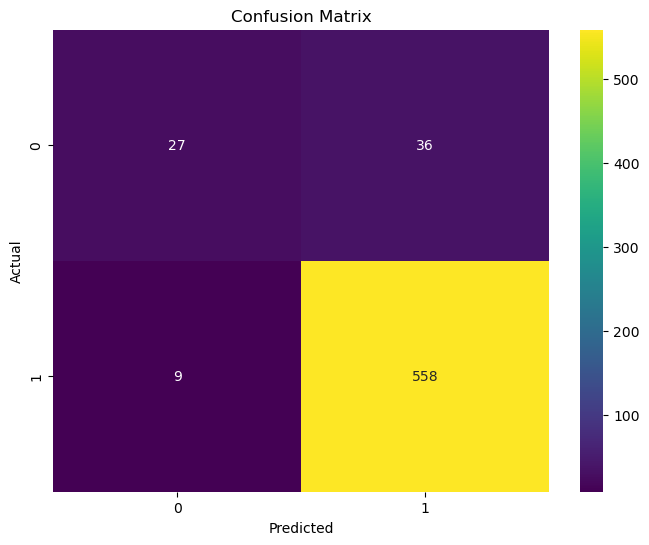

Test accuracy: 0.9285714285714286

Test precision: 0.9393939393939394

Test Recall: 0.9841269841269841

Test F1 score: 0.9612403100775193

classification report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        63
           1       0.94      0.98      0.96       567

    accuracy                           0.93       630
   macro avg       0.84      0.71      0.75       630
weighted avg       0.92      0.93      0.92       630


Train ROC AUC: 0.9533678756476685
Test ROC AUC: 0.7063492063492063


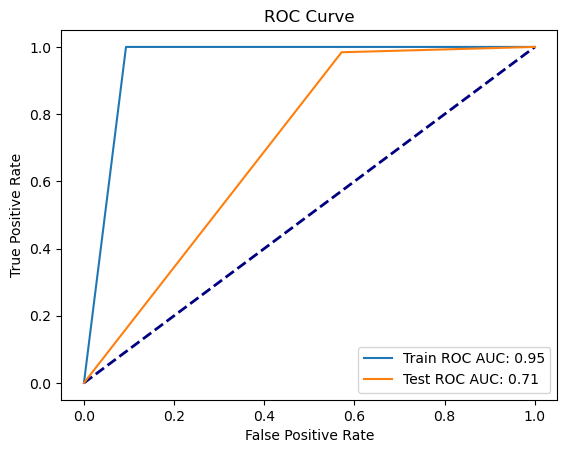

In [198]:
## Model is trained (fit) and predicted in the evaluate model
nn_model_score = evaluate_model(nn_model,  x_train, y_train, x_test, y_test)

In [230]:
# Updated Evaluation metric Score Chart
score['MLP'] = nn_model_score
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB,0.969432,0.912698,1.000000,0.980600,0.967957,0.926667,0.983717,0.952871,0.641093
DT,0.992854,0.915873,1.000000,0.950617,0.992321,0.955674,0.996146,0.953139,0.776896
SVM,0.964272,0.907937,1.000000,1.000000,0.962748,0.907200,0.981021,0.951342,0.539683
MLP,0.992854,0.928571,1.000000,0.984127,0.992321,0.939394,0.996146,0.961240,0.706349


In [200]:
# ML Model - 7 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
param_grid = {'hidden_layer_sizes': np.arange(10, 100, 10),
              'alpha': np.arange(0.0001, 0.01, 0.0001)}

# Initialize the model
neural = MLPClassifier(random_state=0)

# Repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(neural, param_grid, n_iter=10, cv=rskf, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data
random_search.fit(x_train, y_train)

# Select the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'hidden_layer_sizes': 60, 'alpha': 0.0063}


In [201]:

# Initiate model with best parameters
nn_model2 = MLPClassifier(hidden_layer_sizes = best_params['hidden_layer_sizes'],
                        alpha = best_params['alpha'],
                        random_state = 0)

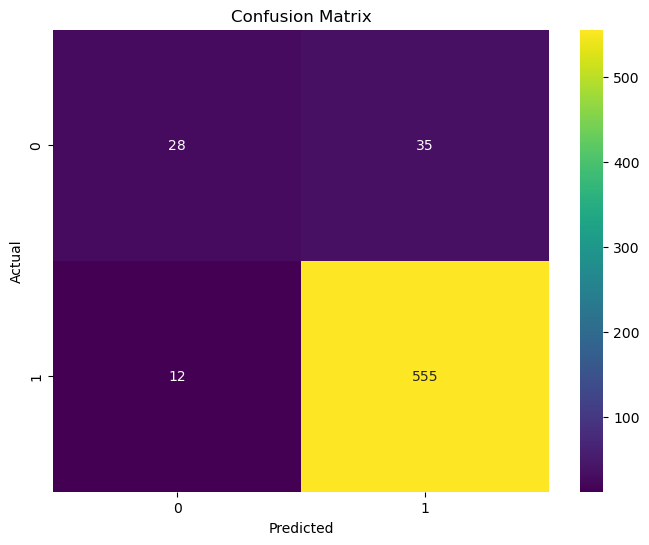

Test accuracy: 0.9253968253968254

Test precision: 0.940677966101695

Test Recall: 0.9788359788359788

Test F1 score: 0.9593777009507347

classification report:
              precision    recall  f1-score   support

           0       0.70      0.44      0.54        63
           1       0.94      0.98      0.96       567

    accuracy                           0.93       630
   macro avg       0.82      0.71      0.75       630
weighted avg       0.92      0.93      0.92       630


Train ROC AUC: 0.9533678756476685
Test ROC AUC: 0.7116402116402116


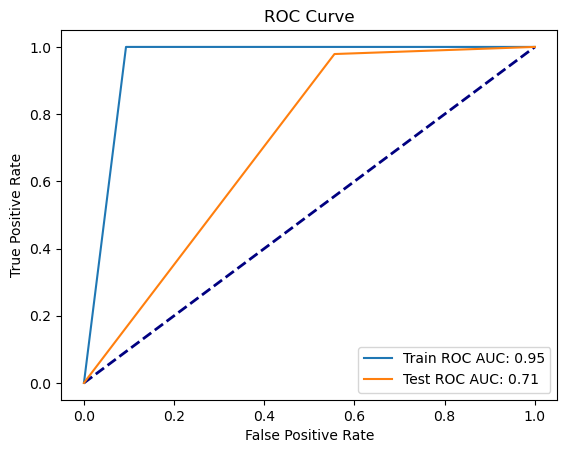

In [202]:
nn_tuned_score = evaluate_model(nn_model2,  x_train, y_train, x_test, y_test)

In [203]:
# Updated Evaluation metric Score Chart
score['MLP Tuned'] = nn_model_score

In [236]:
score.T

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
Logistic Regression,0.976578,0.925397,1.000000,0.989418,0.975262,0.931894,0.987476,0.959795,0.669312
LR Tuned,0.975784,0.923810,1.000000,0.989418,0.974445,0.930348,0.987057,0.958974,0.661376
Random Forest,0.992854,0.923810,1.000000,0.987654,0.992321,0.931780,0.996146,0.958904,0.668430
RF Tuned,0.928146,0.900000,1.000000,1.000000,0.927802,0.900000,0.962549,0.947368,0.500000
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB,0.969432,0.912698,1.000000,0.980600,0.967957,0.926667,0.983717,0.952871,0.641093
DT,0.992854,0.915873,1.000000,0.950617,0.992321,0.955674,0.996146,0.953139,0.776896
SVM,0.964272,0.907937,1.000000,1.000000,0.962748,0.907200,0.981021,0.951342,0.539683
MLP,0.992854,0.928571,1.000000,0.984127,0.992321,0.939394,0.996146,0.961240,0.706349


In [245]:
# Removing the overfitted models which have precision, recall, f1 scores for train as 1
score_t = score.transpose()            # taking transpose of the score dataframe to create new difference column
remove_models = score_t[score_t['Recall Train']==1.00].index  # creating a list of models which have 1 for train and score_t['Accuracy Train']==1.0 and score_t['Precision Train']==1.0 and score_t['F1 macro Train']==1.0
remove_models

adj = score_t.drop(remove_models)                     # creating a new dataframe with required models
adj

,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 macro Train,F1 macro Test,roc auc score
MultinomialNB,0.963081,0.926984,0.992261,0.984127,0.968527,0.937815,0.980251,0.960413,0.698413
MNB Tuned,0.979357,0.930159,0.996131,0.978836,0.981780,0.945486,0.988903,0.961872,0.735450
XGB Tuned,0.953950,0.912698,0.999570,0.987654,0.952869,0.921053,0.975661,0.953191,0.612875


## Conclusion

After evaluating the performance of several machine learning models on the Alexa Review dataset, I have selected the tuned MultinomialNB as our final prediction model. This decision was based on the model’s performance on our primary evaluation metric of recall, which measures the ability of the model to correctly identify different Customer reviews. In our analysis, we found that the MultinomialNB (tuned) had the highest accuracy score on testing data among the models we evaluated. All the other models like Logistic Regression, RF, MLP, DT and XGB are overfitting model as they have precision, recall, f1 scores for train as 1

I choose recall as the primary evaluation metric because correctly identifying dfferent reviews are critical to achieving our business objectives. By selecting a model with a high recall score, we aim to ensure that we correctly identify as many different customer review as possible, even if it means that we may have some false positives. Overall, we believe that the MultinomialNB (tuned) is the best choice for our needs and will help us achieve a positive business impact.Therefore, we can conclude that the best model to implement for analysis of the Alexa reviews is the MultinomialNB (tuned) which has a decent accuracy of 98% on the training data and 93% accuracy on the testing data.